## Question 2 - Asset Pricing Coursework - Group 4

#### Step 0:

In [126]:
# Importing Python Libraries that we will need for this exercise:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### Step 1:

In [129]:
# Importing the data from Excel database into Python while indexing the date column simultaneously:
Prices = pd.read_excel('/Users/macbookpro/Desktop/BAYES/Asset Pricing/COURSEWORK/cw2024AP.xlsx', 'Sheet1', index_col=0)
# Limitting dataset to selected stocks from our Excel model:
Prices_Portfolio = Prices[["ASTRAZENECA", "RIO TINTO", "COMPASS GROUP", "NATWEST GROUP", "SAGE GROUP"]]
# Computing monthly returns and dropping all NaN terms (transforming data from Prices to Returns and cleaning data):
Returns_Portfolio = ((Prices_Portfolio/Prices_Portfolio.shift(1))-1).dropna()
# Converting the simple annual risk free rates to compounded monthly risk free rates:
risk_free_rates = (Prices['UK GVT BMK BID YLD 1M - RED. YIELD']/12)/100

In [131]:
# Defining 6-month rolling periods and aligning with dataset:
rolling_windows = pd.date_range('2014-10-31', '2024-10-31', freq='6MS')
# Aligning rolling windows with the dataset index:
aligned_rolling_windows = [Returns_Portfolio.index[Returns_Portfolio.index.get_indexer([date], method='nearest')[0]]
                           for date in rolling_windows]
# Removing duplicates to avoid overlapping periods
aligned_rolling_windows = sorted(set(aligned_rolling_windows))


In [133]:
# Extracting risk-free rate for each rolling period:
rolling_risk_free_rates = [risk_free_rates.loc[date] if date in risk_free_rates.index else 0.02
                           for date in aligned_rolling_windows]

In [135]:
# Validating risk-free rates alignment to ensure our risk_free_rates data matches the dates in aligned_rolling_windows:
if len(rolling_risk_free_rates) != len(aligned_rolling_windows):
    print("Warning: Mismatch between rolling windows and risk-free rates!")

#### Step 2:

In [138]:
# Initialising DataFrames to store weights separately for each portfolio type:
min_var_weights_data = []
market_portfolio_weights_data = []

# Portfolio Metrics:
def portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate):
    """Calculate portfolio statistics: return, risk (volatility), Sharpe ratio."""
    portfolio_return = weights.dot(mean_returns)
    portfolio_volatility = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

#### Step 3:

In [141]:
# Minimum-Variance Portfolio:
def min_variance_portfolio(mean_returns, cov_matrix):
    """Find weights of the minimum-variance portfolio."""
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(lambda x: np.dot(x.T, np.dot(cov_matrix, x)),
                      num_assets * [1. / num_assets],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

#### Step 4:

In [144]:
# Market Portfolio:
def max_sharpe_portfolio(mean_returns, cov_matrix, risk_free_rate):
    """Find weights of the maximum Sharpe ratio portfolio."""
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        portfolio_return, portfolio_volatility, _ = portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate)
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets], args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

#### Step 5:

In [147]:
# Efficient Frontier:
def efficient_frontier(mean_returns, cov_matrix, num_points=150):
    """Generate efficient frontier points."""
    results = []
    for ret_level in np.linspace(min(mean_returns), max(mean_returns), num_points):
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - ret_level}]
        bounds = tuple((0, 1) for _ in range(len(mean_returns)))
        
        result = minimize(lambda x: np.dot(x.T, np.dot(cov_matrix, x)),
                          len(mean_returns) * [1. / len(mean_returns)],
                          bounds=bounds, constraints=constraints)
        if result.success:
            vol = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
            results.append((vol, ret_level))
    return results

#### Step 6:

In [152]:
# Iterating Through Rolling Windows:
for i, end_date in enumerate(aligned_rolling_windows):
    if end_date not in Returns_Portfolio.index:
        continue
    
    data_subset = Returns_Portfolio.loc[:end_date]
    if len(data_subset) < 2:  # Ensure sufficient data
        print(f"Skipping period ending {end_date} due to insufficient data.")
        continue
    
    mean_returns = data_subset.mean()
    cov_matrix = data_subset.cov()
    
    # Regularising covariance matrix:
    cov_matrix += np.eye(len(cov_matrix)) * 1e-6

    # Calculating Efficient Frontier, Minimum-Variance, and Market Portfolio:
    try:
        frontier_points = efficient_frontier(mean_returns, cov_matrix)
        min_var_weights = min_variance_portfolio(mean_returns, cov_matrix)
        market_weights = max_sharpe_portfolio(mean_returns, cov_matrix, rolling_risk_free_rates[i])

    except Exception as e:
        print(f"Optimization failed for period ending {end_date}: {e}")
        continue

    # Storing weights for this period separately:
    min_var_weights_data.append({'End_Date': end_date.strftime('%Y-%m-%d'),
                                 **{stock: weight for stock, weight in zip(Returns_Portfolio.columns, min_var_weights)}})
    market_portfolio_weights_data.append({'End_Date': end_date.strftime('%Y-%m-%d'),
                                          **{stock: weight for stock, weight in zip(Returns_Portfolio.columns, market_weights)}})

                

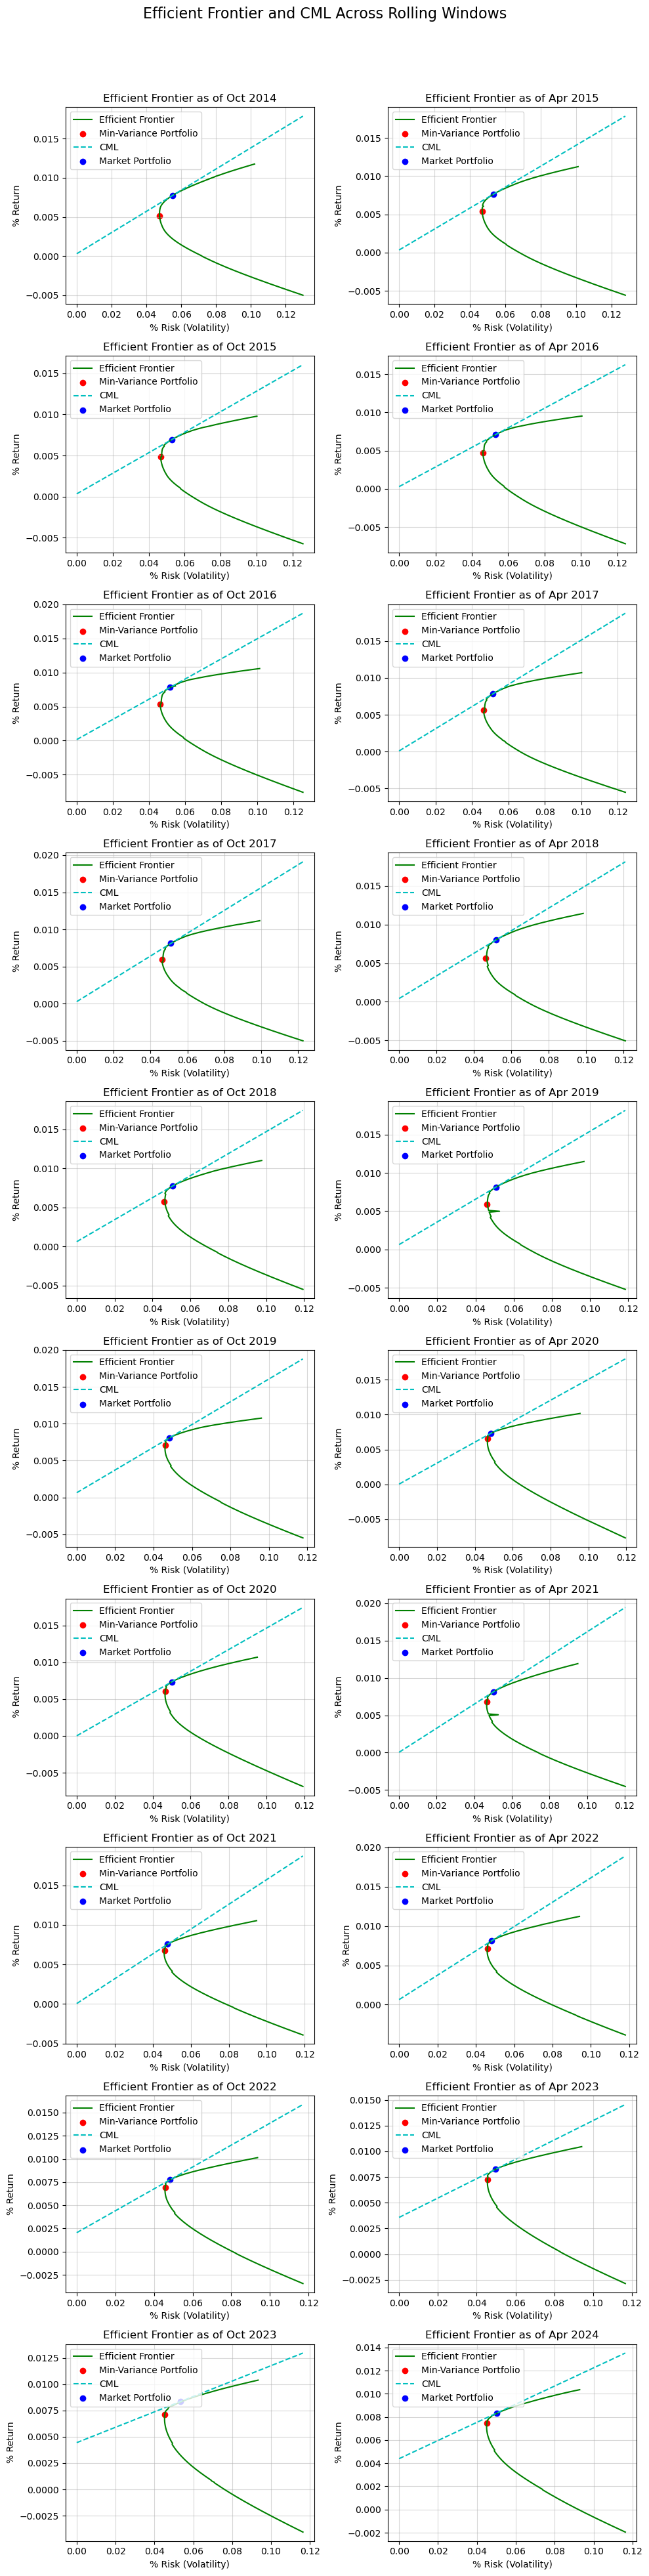

In [153]:
# Create a single figure to stack all the graphs into 10 rows and 2 columns
fig, axes = plt.subplots(10, 2, figsize=(10, 40))
fig.suptitle("Efficient Frontier and CML Across Rolling Windows", fontsize=16)

# Iterate through rolling windows again to plot each graph in its respective subplot
for i, (ax, end_date) in enumerate(zip(axes.flatten(), aligned_rolling_windows)):
    if end_date not in Returns_Portfolio.index:
        continue
    
    data_subset = Returns_Portfolio.loc[:end_date]
    if len(data_subset) < 2:  # Ensure sufficient data
        continue
    
    mean_returns = data_subset.mean()
    cov_matrix = data_subset.cov()
    cov_matrix += np.eye(len(cov_matrix)) * 1e-6  # Regularise covariance matrix

    # Efficient Frontier, Minimum-Variance, and Market Portfolio
    try:
        frontier_points = efficient_frontier(mean_returns, cov_matrix)
        min_var_weights = min_variance_portfolio(mean_returns, cov_matrix)
        market_weights = max_sharpe_portfolio(mean_returns, cov_matrix, rolling_risk_free_rates[i])

        # Plot Efficient Frontier
        ax.plot([p[0] for p in frontier_points], [p[1] for p in frontier_points], 'g-', label='Efficient Frontier')
        
        # Plot Minimum-Variance Portfolio
        min_var_return, min_var_vol, _ = portfolio_stats(min_var_weights, mean_returns, cov_matrix, rolling_risk_free_rates[i])
        ax.scatter(min_var_vol, min_var_return, color='r', label='Min-Variance Portfolio')
        
        # Plot Market Portfolio and CML
        market_return, market_vol, _ = portfolio_stats(market_weights, mean_returns, cov_matrix, rolling_risk_free_rates[i])
        cml_slope = (market_return - rolling_risk_free_rates[i]) / market_vol
        cml_risk = np.linspace(0, max([p[0] for p in frontier_points]), 100)
        cml_return = rolling_risk_free_rates[i] + cml_slope * cml_risk
        ax.plot(cml_risk, cml_return, 'c--', label='CML')

        # Annotate Market Portfolio
        ax.scatter(market_vol, market_return, color='b', label='Market Portfolio')

    except Exception as e:
        print(f"Error plotting for {end_date}: {e}")
        continue

    # Customize each subplot
    ax.set_title(f"Efficient Frontier as of {end_date.strftime('%b %Y')}")
    ax.set_xlabel('% Risk (Volatility)')
    ax.set_ylabel('% Return')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for the global title
plt.savefig('final.png',dpi=500)
plt.show()

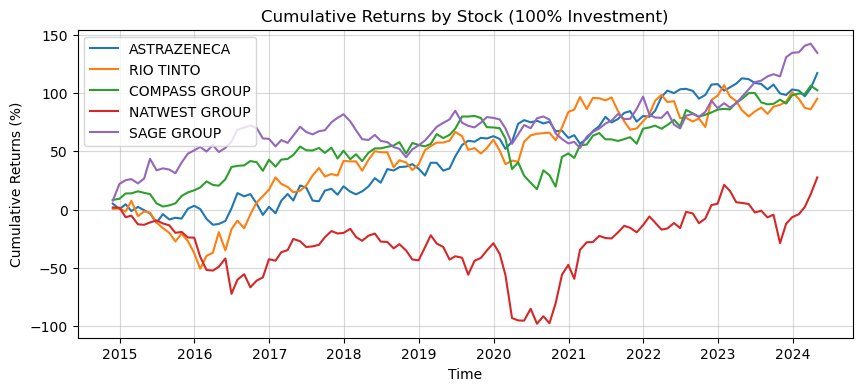

In [156]:
# Filtering data to the range 2014 to 2024:
filtered_data = data_subset.loc['2014-11-01':'2024-11-30']

# Calculating expected returns if investing 100% in each stock and simultaneously converting to percentages:
expected_returns = filtered_data.mean() * 100

# Time series of expected returns:
plt.figure(figsize=(10, 4))
for stock in expected_returns.index:
    plt.plot(filtered_data.index, filtered_data[stock].cumsum() * 100, label=stock)

plt.title("Cumulative Returns by Stock (100% Investment)")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (%)")
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('my_plot.png',dpi=500)  # Supported formats: png, jpg, pdf, svg, etc.

# Optional: Display the plot
plt.show()

#### Step 7:

In [159]:
# Convert Weights Data to DataFrames
min_var_weights_df = pd.DataFrame(min_var_weights_data)
market_portfolio_weights_df = pd.DataFrame(market_portfolio_weights_data)
# Format weights to 6 decimal places for both DataFrames
min_var_weights_df = min_var_weights_df.round(6)
market_portfolio_weights_df = market_portfolio_weights_df.round(6)

Display the resulting DataFrames:

In [162]:
print("Minimum Variance Portfolio Weights:")
min_var_weights_df

Minimum Variance Portfolio Weights:


,End_Date,ASTRAZENECA,RIO TINTO,COMPASS GROUP,NATWEST GROUP,SAGE GROUP
0,2014-10-31,0.430682,0.085653,0.351594,0.040712,0.091359
1,2015-04-30,0.430041,0.092188,0.348325,0.042717,0.086730
2,2015-10-30,0.430905,0.092436,0.349021,0.048353,0.079285
3,2016-04-29,0.425727,0.095883,0.351688,0.046980,0.079721
4,2016-10-31,0.410492,0.082797,0.355541,0.061398,0.089773
5,2017-04-28,0.402492,0.098240,0.350348,0.058535,0.090385
6,2017-10-31,0.395745,0.105705,0.352154,0.060030,0.086367
7,2018-04-30,0.395497,0.102973,0.343270,0.062916,0.095344
8,2018-10-31,0.393626,0.102356,0.344262,0.063243,0.096513
9,2019-04-30,0.389460,0.107449,0.342320,0.063519,0.097252


In [164]:
print("\nMarket Portfolio Weights:")
market_portfolio_weights_df


Market Portfolio Weights:


,End_Date,ASTRAZENECA,RIO TINTO,COMPASS GROUP,NATWEST GROUP,SAGE GROUP
0,2014-10-31,0.255850,0.386476,0.357674,0.0,0.000000
1,2015-04-30,0.207656,0.344780,0.404511,0.0,0.043052
2,2015-10-30,0.155570,0.305722,0.398654,0.0,0.140054
3,2016-04-29,0.106676,0.282690,0.434825,0.0,0.175809
4,2016-10-31,0.136754,0.259782,0.431671,0.0,0.171793
5,2017-04-28,0.140326,0.279234,0.451633,0.0,0.128808
6,2017-10-31,0.152989,0.287504,0.426126,0.0,0.133381
7,2018-04-30,0.173132,0.327379,0.411570,0.0,0.087919
8,2018-10-31,0.251321,0.327570,0.404911,0.0,0.016198
9,2019-04-30,0.182766,0.322735,0.402956,0.0,0.091542


/var/folders/kz/dt5k_c7j6jzcpx7ms12fk6fw0000gn/T/ipykernel_19304/3989980376.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[1, 0, 0.85, 1])  # Spazio aggiunto a destra


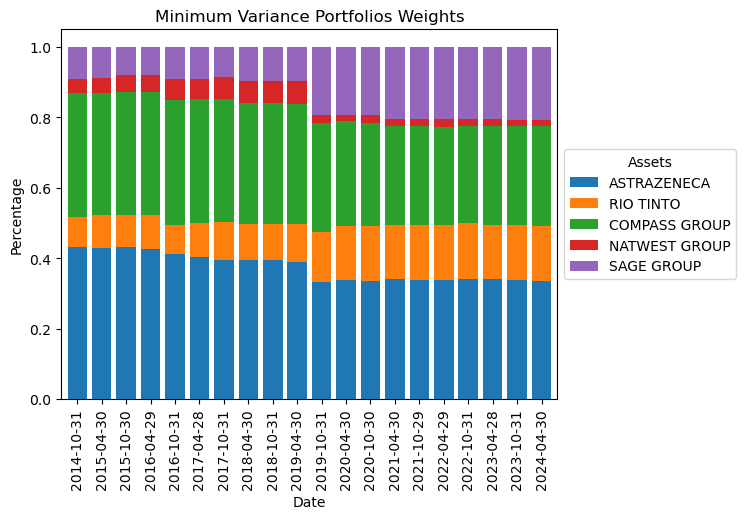

In [166]:
min_var_weights_df.set_index('End_Date').plot(kind='bar', stacked=True, width=0.8, legend=False)
plt.title("Minimum Variance Portfolios Weights")
plt.ylabel("Percentage")
plt.xlabel("Date")

# Aggiungere la legenda a destra del grafico
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Assets", loc="center left", bbox_to_anchor=(1.0, 0.5))

# Aggiustare il layout per fare spazio alla legenda
plt.tight_layout(rect=[1, 0, 0.85, 1])  # Spazio aggiunto a destra

# Salvare l'immagine
plt.savefig('MVweights.png', dpi=500, bbox_inches='tight')

# Mostrare il grafico
plt.show()

/var/folders/kz/dt5k_c7j6jzcpx7ms12fk6fw0000gn/T/ipykernel_19304/1115088934.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[1, 0, 0.85, 1])  # Spazio aggiunto a destra


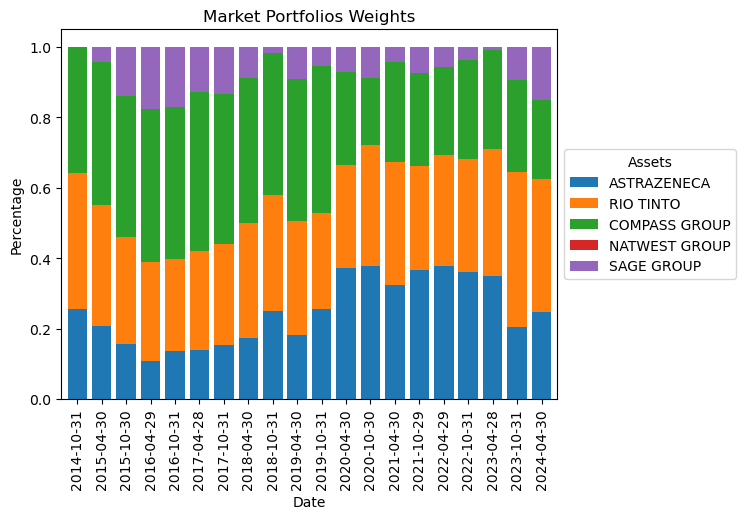

In [168]:
market_portfolio_weights_df.set_index('End_Date').plot(kind='bar', stacked=True, width=0.8, legend=False)
plt.title("Market Portfolios Weights")
plt.ylabel("Percentage")
plt.xlabel("Date")

# Aggiungere la legenda a destra del grafico
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Assets", loc="center left", bbox_to_anchor=(1.0, 0.5))

# Aggiustare il layout per fare spazio alla legenda
plt.tight_layout(rect=[1, 0, 0.85, 1])  # Spazio aggiunto a destra

# Salvare l'immagine
plt.savefig('MPweights.png', dpi=500, bbox_inches='tight')

# Mostrare il grafico
plt.show()

In [110]:
# Optionally save to CSV files
min_var_weights_df.to_csv('min_variance_weights.csv', index=False)
market_portfolio_weights_df.to_csv('market_portfolio_weights.csv', index=False)